Exploration of activity changes

This notebook explores the following features of neural activity:

- Decoding
    - Using
        - Logistic Regression
        - Random forest
        - XGBoost
    - Model characteristics
        - Confusion matrix
        - "Distance"/"predict_proba" matrices
        - Feature importances
    - Comparing
        - Before/after changepoint
        - Autoshape/DRRD
        

- Differences
    - Comparing
        - Before/after changepoint
        - Autoshape/DRRD
    - Measures 
        - Distances
        - Similarities
        - Synchronization
        - Via spikeutils

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Imports-and-functions" data-toc-modified-id="Imports-and-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and functions</a></div><div class="lev1 toc-item"><a href="#Feature-importances" data-toc-modified-id="Feature-importances-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Feature importances</a></div><div class="lev2 toc-item"><a href="#XGBoost" data-toc-modified-id="XGBoost-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>XGBoost</a></div><div class="lev2 toc-item"><a href="#rbfSVM" data-toc-modified-id="rbfSVM-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>rbfSVM</a></div><div class="lev2 toc-item"><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Logistic Regression</a></div>

# Imports and functions

In [35]:

import os
os.chdir('../../')

import pandas as pd
import numpy as np

from itertools import combinations

In [2]:
from sklearn.model_selection import GroupShuffleSplit, cross_val_predict, GroupKFold
from sklearn.base import clone
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [3]:
from spikelearn.data import io
from spikelearn.data.selection import select, to_feature_array

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1]:
def shuffle_val_predict(clf, X, y, group=None, cv=GroupKFold(5), get_weights = True):
    def get_predictions_or_proba(clf, X, mode):
        """
        Local helper function to ease the switching between predict_proba and predict
        """
        if mode == 'predict':
            return pd.DataFrame(clf.predict(X), columns=['predictions'])
        elif mode in ['proba','probability']:
            try:
                return pd.DataFrame(clf.predict_proba(X), columns=np.unique(y))
            except:
                return pd.DataFrame(clf.decision_function(X), columns=np.unique(y))

    weights = pd.DataFrame()
    results = pd.DataFrame()
    n_y = len(np.unique(y))
    for i, (train_idx, test_idx) in enumerate(cv.split(X, y, group)):
        clf_local = clone(clf)
        clf_local.fit(X[train_idx,:],y[train_idx])

        for train_or_test in ['train', 'test']:
            idx = test_idx if train_or_test is 'test' else train_idx
            predictions = get_predictions_or_proba(clf_local, X[idx], 'proba')
            predictions['cv'] = i
            predictions['group'] = group[idx]
            predictions['true'] = y[idx]
            predictions['predictions'] = predictions.apply(lambda x: x.index[np.argmax(x.values[:n_y])], axis=1)
            predictions['mean'] = predictions.apply(lambda x: np.sum(predictions.columns[:len(np.unique(y))].values*x.values[:len(np.unique(y))]), axis=1)
            predictions['set'] = train_or_test
            results = results.append(predictions)

        if get_weights:
            w = pd.DataFrame(clf_local.coef_, columns = np.arange(X.shape[1]), index = pd.Index(np.unique(y).astype(int), name='time'))
            w = w.reset_index().melt(var_name='unit', id_vars=['time'])
            w['shuffle'] = i
            weights=weights.append(w)
    if get_weights:
        return results, weights
    return results



def xyt(df):
    ndf = df.reset_index()
    y = ndf.time.values
    trial = ndf.trial.values
    X = ndf.drop(['time', 'trial'],axis=1).values
    return X, y, trial

def baseline_correct(fa, label):
    epochs = io.load(label, 'epoched_spikes')
    mb = 1/epochs.baseline.apply(len).reset_index().drop('trial', axis=1).groupby('unit').apply(lambda x: np.mean(np.hstack(x.baseline)))

    effective_baseline = select(epochs, is_selected=True).baseline.apply(len)+ mb
    effective_baseline = pd.DataFrame(effective_baseline).reset_index().pivot(columns='unit', index='trial')
    
    df = fa.reset_index().apply(lambda x: [x[2:].values - (1/5)*effective_baseline.loc[x.trial].values], axis=1)
    corrected = pd.DataFrame(np.vstack(df.values).squeeze(), index=fa.index, columns=fa.columns)
    return corrected

def product(X):
    return np.array(list(map(lambda x: x[0]*x[1], combinations(X,2))))
def add_products(X):
    products = np.apply_along_axis(product, 1, X)
    return np.hstack((X, products))

def encode_by_rate_quantile(X, q):
    le, oh = LabelEncoder(), OneHotEncoder()
    
    df = pd.DataFrame(X).apply(lambda x: pd.qcut(x, q, duplicates='drop'))
    df = df.apply(lambda x: le.fit_transform(x))
    sp = pd.DataFrame(index=df.index)
    
    for i in df.columns:
        sp = sp.join(pd.DataFrame(oh.fit_transform(df[i].values.reshape(-1,1)).todense()), rsuffix='_unit_%d'%i, lsuffix='_unit_%d'%i)
    
    return sp

# Feature importances

## XGBoost

In [188]:
from xgboost import XGBClassifier

In [189]:
xgb = XGBClassifier()


In [190]:
sh = GroupShuffleSplit(5, .2, .8)

In [226]:
res2 = shuffle_val_predict(xgb, X, y, trial,sh, get_weights=False)

In [ ]:
train = res.groupby('set').get_group('train')
test = res.groupby('set').get_group('test')

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(train.true, train.predictions))
plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(test.true, test.predictions))

In [218]:
X,y, trial = xyt(corrected)

/home/tevo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  """


In [7]:
ns = io.load('DRRD 8', 'narrow_smoothed')

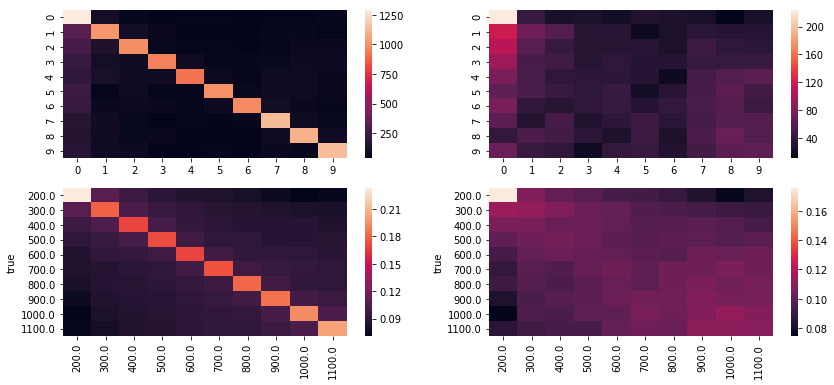

In [228]:
train = res2.groupby('set').get_group('train')
test = res2.groupby('set').get_group('test')

plt.figure(figsize=(14,6))
plt.subplot(2,2,1)
sns.heatmap(confusion_matrix(train.true, train.predictions))
plt.subplot(2,2,2)
sns.heatmap(confusion_matrix(test.true, test.predictions))

plt.subplot(2,2,3)
sns.heatmap(train.groupby('true').mean().iloc[:,:10])
plt.subplot(2,2,4)
sns.heatmap(test.groupby('true').mean().iloc[:,:10])

In [ ]:
xgb.fit(X, y)

In [12]:
def xgb(label, method = 'proba'):
#     params = io.load(rat, 'XGboost')
#     params = dict(zip(params.columns, params.values.reshape(-1)))
#     params['max_depth'] = int(params['max_depth'])
#     params['n_estimators'] = int(params['n_estimators'])
#     params['min_child_weight'] = int(params['min_child_weight'])
    clf = XGBClassifier(n_estimators=12, subsample=.5, gamma=0.1, max_depth=16)
    
    s = io.load(label, 'wide_smoothed')
    X,y, trial = to_feature_array(select(s.reset_index(), _min_duration=1.5, _min_trial=100, is_tired=False).set_index(['trial','unit']), subset='cropped')
    
    res = shuffle_val_predict(clf, X, y, trial, GroupShuffleSplit(30, 10, 80),method)
    clf = clf.fit(X, y)
    
    return res, clf

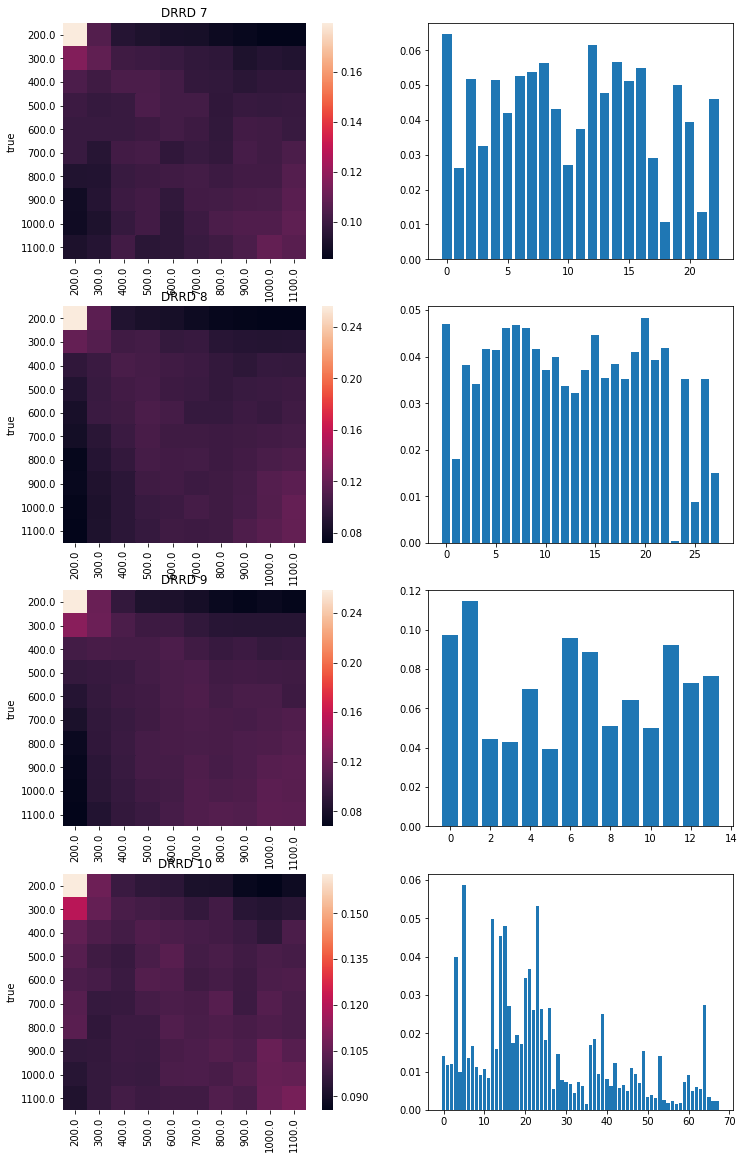

In [61]:
plt.figure(figsize=(12, 20))
for i, rat in enumerate(['DRRD %d'%n for n in [7,8,9,10]]):
    res, clf = xgb(rat)
    
    plt.subplot(4, 2, 2*i+1)
    sns.heatmap(res.drop(['cv','group'],axis=1).groupby('true').mean()); plt.title(rat)
    plt.subplot(4, 2, 2*i+2)
    plt.bar(np.arange(clf.feature_importances_.shape[0]),clf.feature_importances_)

In [17]:
res, clf = xgb('DRRD 8', 'predict')

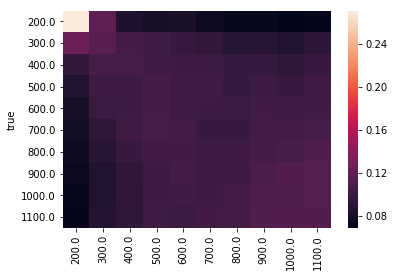

In [16]:
sns.heatmap(res.drop(['cv','group'],axis=1).groupby('true').mean())

---

## rbfSVM

In [148]:
from sklearn.svm import SVC

In [145]:
params = io.load('DRRD 7', 'rbfSVM')
params= dict(zip(params.columns, params.values.reshape(-1)))

In [149]:
clf = SVC(**params)

In [150]:
def get_predictions_or_proba(clf, X, mode):
    """
    Local helper function to ease the switching between predict_proba and predict
    """
    if mode == 'predict':
        return clf.predict(X)
    elif mode in ['proba','probability']:
        try:
            return clf.predict_proba(X)
        except:
            return clf.decision_function(X)
n_shuffles=10
train_size=.8
test_size=.2

results = pd.DataFrame(columns = ['trial', 'shuffle', 'predictions','true'])
sh = GroupShuffleSplit(n_splits=n_shuffles, train_size=train_size,test_size=test_size)

for i, (train_idx, test_idx) in enumerate(sh.split(X,y,trial)):
    clf_local = clone(clf)
    clf_local.fit(X[train_idx,:],y[train_idx])

    predictions = get_predictions_or_proba(clf_local, X[test_idx], 'predict' )
    true = y[test_idx]
    results = results.append(pd.DataFrame({'shuffle':i, 'predictions': predictions,
                                            'trial':trial[test_idx], 'true':true} ) )

## Logistic Regression

In [61]:
from ipywidgets import interact, HBox, interactive_output, interact_manual
import ipywidgets.widgets as wdg

from IPython.display import display

from scipy.stats import pearsonr


from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

In [62]:
srat = wdg.Dropdown(options=['DRRD %d'%i for i in [7,8,9,10]])
sdset = wdg.Dropdown(options=['narrow_smoothed','narrow_smoothed_viz', 'wide_smoothed'])
snsplits = wdg.IntSlider(min=2,max=10)

d = HBox([srat,sdset,snsplits])


def choose_rat(label, n_splits, dset):
    unselected = io.load(label, dset).reset_index()
    minTrial=unselected.trial.min()
    maxTrial=unselected.trial.max()
    
    # TODO change selection to inside, and add selection 'range'
    
    sh = GroupShuffleSplit(n_splits=n_splits, train_size=.8,test_size=.2)
    
    @interact_manual(logC = wdg.FloatSlider(min=-6, max=8,step=.25, continuous_update=False),
              penalty = wdg.Dropdown(options=['l1','l2']), 
              trials = wdg.IntRangeSlider(min=minTrial, max=maxTrial, value=(minTrial, maxTrial), continuous_update=False),
              duration = wdg.FloatRangeSlider(min=.5,max=10, value=(1.5,10), continuous_update=False),
              intercept=True)
    def choose_regularization(logC, penalty,intercept, trials, duration):
        data = select(unselected, _min_duration=duration[0], _max_duration=duration[1], _mineq_trial=trials[0], _maxeq_trial=trials[1]).set_index(['trial', 'unit'])
        Xab, y, trial = xyt(baseline_correct(to_feature_array(data, False), label))
        X = ss.fit_transform(add_products(Xab))
        
        
        clf = LogisticRegression(C=10**logC, penalty=penalty, fit_intercept=intercept)
        allres = pd.DataFrame()
        fig, ax = plt.subplots(2, 2, figsize=(20,12));
        #disp =display(fig,display_id='fig')
        res, weights_full = shuffle_val_predict(clf, X, y, trial, cv=sh, get_weights = True)
        #allres = allres.append(res.groupby('true').mean().drop(['cv', 'group'],axis=1)).groupby('true').mean()
        train = res.groupby('set').get_group('train')
        test  = res.groupby('set').get_group('test')

        train_proba = train.groupby('true').mean().drop(['cv', 'group','predictions', 'mean'],axis=1)
        test_proba = test.groupby('true').mean().drop(['cv', 'group','predictions', 'mean'],axis=1)

        # Plot train results

        axt = plt.subplot(3,4,1);    sns.heatmap(train_proba, ax=axt, cbar=False); plt.title('Train probabilities')
        axt = plt.subplot(3,4,2);    sns.heatmap(confusion_matrix(train.true, train.predictions), ax=axt, cbar=False); plt.title('Train predictions')

        # Plot test results
        axt = plt.subplot(3,4,5);    sns.heatmap(test_proba, ax=axt, cbar=False); plt.title('Test probabilities')
        axt = plt.subplot(3,4,6);    sns.heatmap(confusion_matrix(test.true, test.predictions), ax=axt, cbar=False); plt.title('Test predictions')

        c = sns.palettes.color_palette('viridis', X.shape[1])
        
        
        weights = weights_full.applymap(abs).groupby('unit').mean().reset_index().value
        w = (weights.sort_values()/weights.max()).values **2
        rank = weights.argsort().values
        
        activity = pd.DataFrame(X[:,rank], index=y).reset_index()
        mean = activity.groupby('index').mean()
        std = activity.groupby('index').std()/np.sqrt(np.unique(trial).shape[0])
        
        
        # Weights
        axt = plt.subplot(3,4,3)
        sns.barplot('unit','value', data=weights_full.abs(), ax=axt, palette=np.array(c)[np.argsort(rank)]); plt.title('(abs) Weight of each neuron')
        #plt.ylim([0,.2])
        
        axt = plt.subplot(3,4,4)
        for i, line in mean.transpose().iterrows():
            plt.plot(line, alpha=w[i], linewidth=4*(i**1.1)/X.shape[1], color=c[i])
            plt.fill_between(np.unique(y), line+std[i], line-std[i], alpha=w[i]/2, color=c[i])
        plt.title('Mean activity of neurons')
            
        train_r = pearsonr(train.true, train['mean'])[0]
        test_r = pearsonr(test.true, test['mean'])[0]
        rs = pd.DataFrame([train_r, test_r],index=['Train','Test'], columns =['r']).reset_index()
        
        sns.barplot('r','index',data=rs,ax=plt.subplot(6,4,11)); plt.xlim([0,0.5]); plt.title('Score using expected value')
        
        train_r = pearsonr(train.true, train.predictions)[0]
        test_r = pearsonr(test.true, test.predictions)[0]
        rs = pd.DataFrame([train_r, test_r],index=['Train','Test'], columns =['r']).reset_index()
        sns.barplot('r','index',data=rs,ax=plt.subplot(6,4,15)); plt.xlim([0,0.5]); plt.title('Score using maximum likelihood')
        

        plt.subplot(3,4,8)
        mean_weight = (weights_full.groupby(['unit','time']).agg(np.mean)).value.reset_index().pivot(columns='time', index='unit').iloc[rank].reset_index(drop=True)
        var_weight = (weights_full.groupby(['unit','time']).agg(np.std)/np.sqrt(weights_full.shuffle.unique().shape[0])).value.reset_index().pivot(columns='time', index='unit').iloc[rank].reset_index(drop=True)       
        
        for i in range(weights_full.unit.unique().shape[0]):
            line = mean_weight.iloc[i,:].values
            std = var_weight.iloc[i,:].values
            plt.plot(np.unique(y),line, alpha=w[i], linewidth=4*(i**1.1)/X.shape[1], color=c[i])
            plt.fill_between(np.unique(y), line+std, line-std, alpha=w[i]/2, color=c[i])
        plt.title('Mean weight for each time')
        
        
        # Trials being used
        
        def trial_matrix(df):
            A = np.zeros((1200,2))
            A[df.groupby('set').get_group('train').group.unique(),0] = -1
            A[df.groupby('set').get_group('test').group.unique(),1] = 1
            return A.transpose()
    
        trial_sets = pd.DataFrame(res.groupby(['cv']).apply(trial_matrix), columns=['Trials'])
        each_set = pd.DataFrame.join(trial_sets.applymap(lambda x: (x==1).sum()), trial_sets.applymap(lambda x: (x==-1).sum()), lsuffix='_test', rsuffix='_train').reset_index().melt(id_vars='cv')
        sns.barplot(x='value', y='variable', data=each_set, ax=plt.subplot(3,4,12))
        
        #sns.heatmap(set1, ax=plt.subplot(3,4,12))
        # TODO jointplot mean activity vs weight at each time, with one point per shuffle
        #sns.jointplot()
        
        plt.tight_layout()
        
out = interactive_output(choose_rat, dict(label=srat, n_splits = snsplits, dset = sdset))
display(d, out)

HBox(children=(Dropdown(options=('DRRD 7', 'DRRD 8', 'DRRD 9', 'DRRD 10'), value='DRRD 7'), Dropdown(options=('narrow_smoothed', 'narrow_smoothed_viz', 'wide_smoothed'), value='narrow_smoothed'), IntSlider(value=2, max=10, min=2)))

Output()